In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch
from torch.utils.data import Dataset
sys.path.append(os.path.abspath(".."))

## Load and Split the data

In [2]:
from utils.loader import load_data_with_logReturn

data_clean = load_data_with_logReturn("../stocks/AAPL.csv")

In [3]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11182 entries, 1980-12-22 to 2025-05-02
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       11182 non-null  float64
 1   Close           11182 non-null  float64
 2   High            11182 non-null  float64
 3   Low             11182 non-null  float64
 4   Open            11182 non-null  float64
 5   Volume          11182 non-null  int64  
 6   LogReturn       11182 non-null  float64
 7   LogReturn_Lag1  11182 non-null  float64
 8   LogReturn_Lag2  11182 non-null  float64
 9   LogReturn_Lag3  11182 non-null  float64
 10  LogReturn_Lag4  11182 non-null  float64
 11  LogReturn_Lag5  11182 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


Feature Engineering for the input layer. Now set the slide window size for 10 days, i.e 10x10 = 100 neurons.

In [4]:
class MLP_Dataset(Dataset):
    def __init__(self, df, window):
        self.window = window
        self.X, self.y = self.create_features(df)

    def create_features(self, df):
        X_list, y_list = [], []
        for i in range(self.window, len(df) - 1):
            window_data = df.iloc[i-self.window:i][[
                "Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
            ]].values  # shape: (10, 10)

            flat_window = window_data.flatten()
            X_list.append(flat_window) 
            y_list.append(df["LogReturn"].iloc[i+1])  # or LogReturn, etc.

        X_array = np.array(X_list)
        y_array = np.array(y_list)
        return torch.tensor(X_array, dtype=torch.float32), torch.tensor(y_array, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
batch_size = 64

# Normailize data
feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
                "LogReturn_Lag4", "LogReturn_Lag5"]

scaler = StandardScaler()
data_clean_scaler = data_clean.copy()
data_clean_scaler[feature_cols] = scaler.fit_transform(data_clean_scaler[feature_cols])

# Assume data_clean is already prepared
dataset = MLP_Dataset(data_clean_scaler, window=20)

# Get all timestamps from the original DataFrame
all_dates = data_clean.index.tolist()

# Determine the ending date of each sample (starts from index=10 due to window)
sample_end_dates = all_dates[10:len(dataset) + 10]  # offset by window size

# Define date boundaries for each split
train_val_start_date = pd.Timestamp("1985-01-01")
train_val_end_date = pd.Timestamp("2024-12-31")
test_start_date = pd.Timestamp("2025-01-01")
test_end_date = pd.Timestamp("2025-05-02")

# Find dataset indices corresponding to each date range
train_val_indices = [
    i for i, date in enumerate(sample_end_dates)
    if train_val_start_date <= date <= train_val_end_date
]

# Time-based 80-20 split
train_size = int(len(train_val_indices) * 0.8)
train_indices = train_val_indices[:train_size]
val_indices = train_val_indices[train_size:]

test_indices = [
    i for i, date in enumerate(sample_end_dates)
    if test_start_date <= date <= test_end_date
]

# Create subsets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [6]:
print("Number of samples:", len(dataset))
print("Input feature shape:", dataset[0][0].shape)
print("Target value:", dataset[0][1])

Number of samples: 11161
Input feature shape: torch.Size([200])
Target value: tensor(0.0115)


## Model

Define MLP Model

In [7]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return x


Training

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = MLP(input_size=train_set.dataset.X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
from tqdm import tqdm

epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        progress_bar.set_postfix(loss=avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device).unsqueeze(1)
            val_outputs = model(X_val_batch)
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item() * X_val_batch.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

Epoch 1, Train Loss: 0.001686, Val Loss: 0.000364


Epoch 2, Train Loss: 0.000927, Val Loss: 0.000458


Epoch 3, Train Loss: 0.000869, Val Loss: 0.000356


Epoch 4, Train Loss: 0.000858, Val Loss: 0.000359


Epoch 5, Train Loss: 0.000851, Val Loss: 0.000406


Epoch 6, Train Loss: 0.000843, Val Loss: 0.000802


Epoch 7, Train Loss: 0.000834, Val Loss: 0.000455


Epoch 8, Train Loss: 0.000833, Val Loss: 0.000444


Epoch 9, Train Loss: 0.000826, Val Loss: 0.000616


Epoch 10, Train Loss: 0.000818, Val Loss: 0.001055


Epoch 11, Train Loss: 0.000805, Val Loss: 0.000884


Epoch 12, Train Loss: 0.000799, Val Loss: 0.000512


Epoch 13, Train Loss: 0.000817, Val Loss: 0.000730


Epoch 14, Train Loss: 0.000778, Val Loss: 0.000472


Epoch 15, Train Loss: 0.000813, Val Loss: 0.001473


Epoch 16, Train Loss: 0.000778, Val Loss: 0.000782


Epoch 17, Train Loss: 0.000754, Val Loss: 0.000398


Epoch 18, Train Loss: 0.000770, Val Loss: 0.000462


Epoch 19, Train Loss: 0.000760, Val Loss: 0.000380


Epoch 20, Train Loss: 0.000705, Val Loss: 0.000401


In [10]:
from utils.plotter import plot_actual_vs_predicted_prices

# After training loop
model.eval()

# Predict for each dataset
def predict(loader, index_list):
    preds = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().squeeze())
            actuals.append(y_batch)
    preds_tensor = torch.cat(preds)
    actuals_tensor = torch.cat(actuals)

    # Convert to pandas.Series with matching indices
    return (
        pd.Series(preds_tensor.numpy(), index=index_list),
        pd.Series(actuals_tensor.numpy(), index=index_list)
    )

# Find correct responding X
X_train_dates = [sample_end_dates[i] for i in train_indices]
X_val_dates   = [sample_end_dates[i] for i in val_indices]
X_test_dates  = [sample_end_dates[i] for i in test_indices]

X_train = data_clean.loc[X_train_dates]
X_val   = data_clean.loc[X_val_dates]
X_test  = data_clean.loc[X_test_dates]

y_train_pred, y_train_true = predict(train_loader, X_train_dates)
y_val_pred,   y_val_true   = predict(val_loader, X_val_dates)
y_test_pred,  y_test_true  = predict(test_loader, X_test_dates)


In [11]:
from sklearn.metrics import r2_score, root_mean_squared_error

print("Validation R²:", r2_score(y_val_true, y_val_pred))
print("Validation RMSE:", root_mean_squared_error(y_val_true, y_val_pred))
print("Test R²:", r2_score(y_test_true, y_test_pred))
print("Test RMSE:", root_mean_squared_error(y_test_true, y_test_pred))

Validation R²: -0.17784929275512695
Validation RMSE: 0.02002984657883644
Test R²: -0.24437105655670166
Test RMSE: 0.033604931086301804


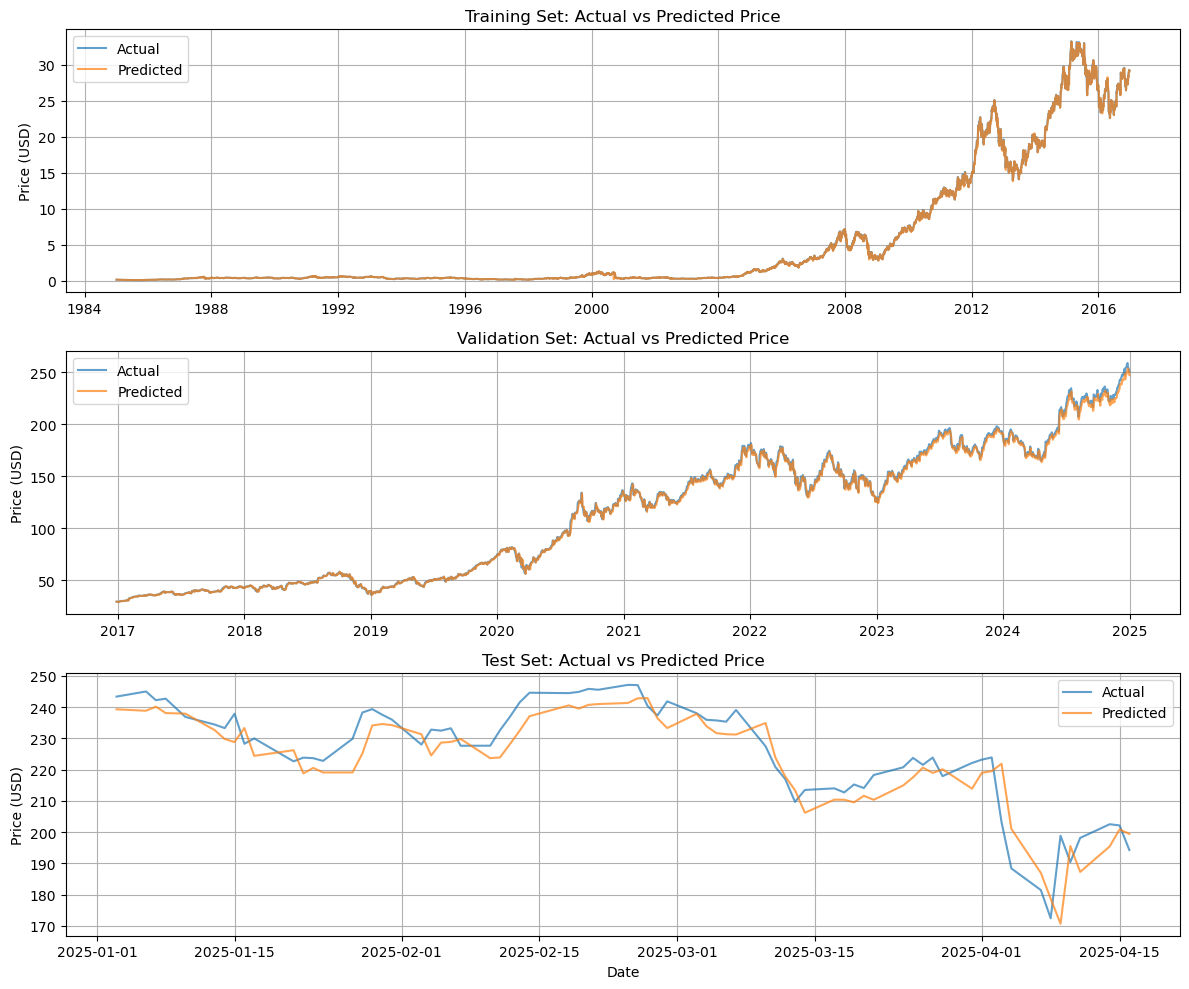

In [ ]:
plot_actual_vs_predicted_prices(
    X_train, y_train_true, y_train_pred,
    X_val,   y_val_true,   y_val_pred,
    X_test,  y_test_true,  y_test_pred
)


Trading Simulation

In [20]:
from utils.eval import evaluate_strategy_performance,calculate_average_pnl

returns, capital, test_positions = evaluate_strategy_performance(
            y_val_true,
            y_val_pred,
            y_test_true,
            y_test_pred
        )

pnl_result = calculate_average_pnl(test_positions, y_test_true)

In [21]:
summary = {
            "Val Return": returns["Validation Cumulative Return"],
            "Val Sharpe": returns["Validation Sharpe Ratio"],
            "Test Return": returns["Test Cumulative Return"],
            "Test Sharpe": returns["Test Sharpe Ratio"],
            "Final Val Capital": capital["Final Val Capital"],
            "Final Test Capital": capital["Final Test Capital"],
            "Average PnL": pnl_result["average_pnl"],
            "Average PnL (%)": pnl_result["average_pnl_percent"]
        }

In [19]:
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
display(summary_df)

,Value
Val Return,-7.915775e-01
Val Sharpe,-7.445639e-01
Test Return,1.199415e-01
Test Sharpe,8.290474e-01
Final Val Capital,2.084225e+05
Final Test Capital,1.119942e+06
Average PnL,2.026032e+03
Average PnL (%),2.026032e-01


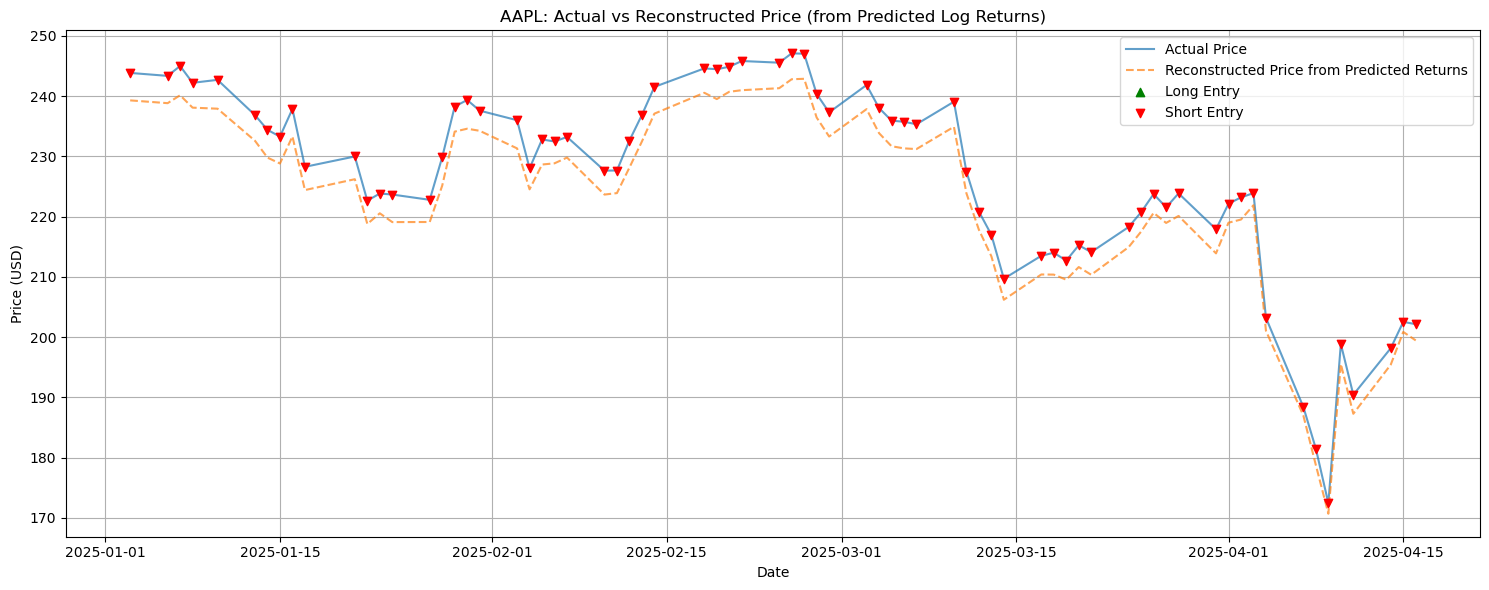

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Long/Short markers
long_signals = (test_positions == 1)
short_signals = (test_positions == -1)

# Dates and data alignment
test_dates = y_test_true.index
plot_dates = test_dates[1:]

P_t = X_test.Close.iloc[:-1].values
r_hat_t_plus_1 = y_test_pred[1:]
P_hat_t_plus_1 = P_t * np.exp(r_hat_t_plus_1)

# Ensure same length across all series
min_len = min(len(plot_dates), len(P_hat_t_plus_1))
plot_dates = plot_dates[:min_len]
P_hat_t_plus_1 = P_hat_t_plus_1[:min_len]
actual_prices = X_test.Close.values[:min_len]

long_signals = long_signals[1:][:min_len]
short_signals = short_signals[1:][:min_len]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(plot_dates, actual_prices, label="Actual Price", alpha=0.7)
plt.plot(plot_dates, P_hat_t_plus_1, label="Reconstructed Price from Predicted Returns", linestyle="--", alpha=0.7)

plt.scatter(plot_dates[long_signals], actual_prices[long_signals], marker='^', color='green', label='Long Entry', zorder=5)
plt.scatter(plot_dates[short_signals], actual_prices[short_signals], marker='v', color='red', label='Short Entry', zorder=5)

plt.title("AAPL: Actual vs Reconstructed Price (from Predicted Log Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
